In [76]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import pickle
from sklearn.preprocessing import StandardScaler

In [66]:
dataset = []
image = nib.load('./ADNI_011_S_0010_PET_30_min_3D_FDG_4i_16s__br_raw_20051114113046731_1_S10060_I8664.nii')
dataset.append(np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max())
dataset = np.array(dataset)

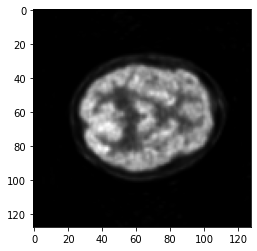

In [67]:
plt.imshow(dataset[0][:,:,32],cmap='gray')
plt.show()

In [50]:
class SuperVoxel():
    '''Class to represent a supervoxel'''
    def __init__(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))
        self.voxels = {}
        
    def update(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))

    def describe(self):
        print("Coordinates: ",self.coord," Intensity: ",self.i, " Voxel Count: ",len(self.voxels))
      
        

In [68]:
def imageConvert(img,clusters):
    image = np.asarray(img).copy()
    for c in tqdm(clusters):
        for x,y,z in c.voxels:
            image[x,y,z]=c.i
    return image

In [99]:
#Importing file
pkl = open('clusters.pkl','rb')

clusters = pickle.load(pkl)

pkl.close()

In [100]:
for c in clusters:
    c.describe()

Coordinates:  [1 1 1]  Intensity:  0.0  Voxel Count:  63
Coordinates:  [1 1 6]  Intensity:  0.0  Voxel Count:  72
Coordinates:  [ 1  1 11]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [ 1  1 16]  Intensity:  0.0  Voxel Count:  66
Coordinates:  [ 1  1 21]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [ 1  1 26]  Intensity:  0.0  Voxel Count:  71
Coordinates:  [ 1  1 31]  Intensity:  0.0  Voxel Count:  77
Coordinates:  [ 1  1 36]  Intensity:  0.0  Voxel Count:  76
Coordinates:  [ 1  1 41]  Intensity:  0.0  Voxel Count:  78
Coordinates:  [ 1  1 46]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [ 1  1 51]  Intensity:  0.0  Voxel Count:  72
Coordinates:  [ 1  1 56]  Intensity:  0.0  Voxel Count:  66
Coordinates:  [ 1  1 60]  Intensity:  0.0  Voxel Count:  62
Coordinates:  [1 5 1]  Intensity:  0.0  Voxel Count:  70
Coordinates:  [1 5 5]  Intensity:  0.0  Voxel Count:  99
Coordinates:  [ 1  5 11]  Intensity:  0.0  Voxel Count:  99
Coordinates:  [ 1  5 15]  Intensity:  0.0  Voxel Cou

Coordinates:  [ 5 74 56]  Intensity:  0.006164738914151433  Voxel Count:  144
Coordinates:  [ 6 77 58]  Intensity:  9.155552842799158e-05  Voxel Count:  61
Coordinates:  [ 6 78  1]  Intensity:  0.0  Voxel Count:  76
Coordinates:  [ 2 77  4]  Intensity:  0.00015259254737998596  Voxel Count:  104
Coordinates:  [ 4 80  8]  Intensity:  0.0  Voxel Count:  112
Coordinates:  [ 5 82 13]  Intensity:  0.000793481246375927  Voxel Count:  113
Coordinates:  [ 6 80 20]  Intensity:  0.0  Voxel Count:  97
Coordinates:  [ 4 79 24]  Intensity:  9.155552842799158e-05  Voxel Count:  124
Coordinates:  [ 4 80 31]  Intensity:  0.0  Voxel Count:  147
Coordinates:  [ 3 79 37]  Intensity:  0.0  Voxel Count:  79
Coordinates:  [ 5 80 41]  Intensity:  0.0  Voxel Count:  111
Coordinates:  [ 4 78 46]  Intensity:  0.0010376293221839045  Voxel Count:  136
Coordinates:  [ 2 80 51]  Intensity:  0.0004577776421399579  Voxel Count:  100
Coordinates:  [ 5 79 54]  Intensity:  0.0008545182653279214  Voxel Count:  100
Coordin

Coordinates:  [15 42 45]  Intensity:  0.0003051850947599719  Voxel Count:  156
Coordinates:  [12 39 50]  Intensity:  0.000640888698995941  Voxel Count:  144
Coordinates:  [15 40 55]  Intensity:  0.006073183385723441  Voxel Count:  163
Coordinates:  [12 38 60]  Intensity:  0.0  Voxel Count:  144
Coordinates:  [14 45  1]  Intensity:  0.0017090365306558428  Voxel Count:  124
Coordinates:  [15 44  7]  Intensity:  0.00021362956633198035  Voxel Count:  148
Coordinates:  [17 45 12]  Intensity:  3.051850947599719e-05  Voxel Count:  162
Coordinates:  [13 44 16]  Intensity:  0.0053102206488235115  Voxel Count:  147
Coordinates:  [13 43 21]  Intensity:  0.0  Voxel Count:  131
Coordinates:  [14 44 27]  Intensity:  0.00015259254737998596  Voxel Count:  140
Coordinates:  [19 42 33]  Intensity:  0.0  Voxel Count:  45
Coordinates:  [15 45 34]  Intensity:  0.0  Voxel Count:  161
Coordinates:  [14 44 39]  Intensity:  0.00015259254737998596  Voxel Count:  138
Coordinates:  [15 48 44]  Intensity:  0.00015

Coordinates:  [23  3 34]  Intensity:  0.0004882961516159551  Voxel Count:  131
Coordinates:  [25  5 40]  Intensity:  0.0  Voxel Count:  131
Coordinates:  [25  5 45]  Intensity:  0.0  Voxel Count:  133
Coordinates:  [26  5 50]  Intensity:  0.0  Voxel Count:  91
Coordinates:  [24  5 54]  Intensity:  0.0  Voxel Count:  117
Coordinates:  [24  5 58]  Intensity:  0.0004882961516159551  Voxel Count:  130
Coordinates:  [25 11  1]  Intensity:  0.0  Voxel Count:  78
Coordinates:  [24  9  6]  Intensity:  0.0  Voxel Count:  119
Coordinates:  [23 10 11]  Intensity:  0.0  Voxel Count:  108
Coordinates:  [23  9 16]  Intensity:  0.0  Voxel Count:  92
Coordinates:  [25  9 21]  Intensity:  0.0  Voxel Count:  90
Coordinates:  [23 10 25]  Intensity:  0.0  Voxel Count:  132
Coordinates:  [23  8 29]  Intensity:  3.051850947599719e-05  Voxel Count:  127
Coordinates:  [25  8 34]  Intensity:  0.00012207403790398877  Voxel Count:  170
Coordinates:  [25 10 39]  Intensity:  0.0  Voxel Count:  119
Coordinates:  [2

Coordinates:  [27 98 24]  Intensity:  0.0  Voxel Count:  94
Coordinates:  [ 31 100  31]  Intensity:  0.0  Voxel Count:  114
Coordinates:  [ 30 101  35]  Intensity:  0.0  Voxel Count:  106
Coordinates:  [ 30 101  40]  Intensity:  0.0  Voxel Count:  95
Coordinates:  [ 30 100  46]  Intensity:  0.0  Voxel Count:  125
Coordinates:  [28 99 50]  Intensity:  0.0004577776421399579  Voxel Count:  121
Coordinates:  [29 99 55]  Intensity:  0.0  Voxel Count:  132
Coordinates:  [28 98 60]  Intensity:  0.0022888882106997894  Voxel Count:  142
Coordinates:  [ 33 104   1]  Intensity:  0.000946073793755913  Voxel Count:  77
Coordinates:  [ 26 103   4]  Intensity:  0.0  Voxel Count:  102
Coordinates:  [ 26 103  10]  Intensity:  0.0  Voxel Count:  0
Coordinates:  [ 28 103  14]  Intensity:  3.051850947599719e-05  Voxel Count:  134
Coordinates:  [ 29 104  21]  Intensity:  0.0  Voxel Count:  114
Coordinates:  [ 30 106  26]  Intensity:  0.0  Voxel Count:  69
Coordinates:  [ 30 105  31]  Intensity:  0.0  Voxel

Coordinates:  [39 79 45]  Intensity:  0.47669911801507614  Voxel Count:  185
Coordinates:  [39 77 51]  Intensity:  0.03671376689962462  Voxel Count:  106
Coordinates:  [40 80 55]  Intensity:  0.02087466048158208  Voxel Count:  108
Coordinates:  [38 79 60]  Intensity:  0.003173924985503708  Voxel Count:  113
Coordinates:  [38 82  2]  Intensity:  0.03430280465102085  Voxel Count:  115
Coordinates:  [39 85  5]  Intensity:  0.013733329264198737  Voxel Count:  90
Coordinates:  [39 85 10]  Intensity:  0.058412427137058624  Voxel Count:  140
Coordinates:  [40 85 16]  Intensity:  0.11053804132206183  Voxel Count:  134
Coordinates:  [38 84 19]  Intensity:  0.11758781701101718  Voxel Count:  128
Coordinates:  [36 84 27]  Intensity:  0.08194219794305246  Voxel Count:  153
Coordinates:  [37 85 31]  Intensity:  0.4380016479995117  Voxel Count:  112
Coordinates:  [37 85 35]  Intensity:  0.6355479598376416  Voxel Count:  122
Coordinates:  [38 85 39]  Intensity:  0.5909604174932096  Voxel Count:  141


Coordinates:  [49 44 53]  Intensity:  0.023529770805993836  Voxel Count:  128
Coordinates:  [48 43 60]  Intensity:  0.00946073793755913  Voxel Count:  123
Coordinates:  [47 49  0]  Intensity:  0.1357463301492355  Voxel Count:  75
Coordinates:  [46 51  5]  Intensity:  0.07797479171117283  Voxel Count:  0
Coordinates:  [49 50 11]  Intensity:  0.6112552262947477  Voxel Count:  141
Coordinates:  [47 48 15]  Intensity:  0.4164250617999817  Voxel Count:  130
Coordinates:  [48 52 20]  Intensity:  0.4545731986449782  Voxel Count:  131
Coordinates:  [49 49 23]  Intensity:  0.5521408734397412  Voxel Count:  148
Coordinates:  [49 49 31]  Intensity:  0.20310068056276132  Voxel Count:  53
Coordinates:  [49 48 35]  Intensity:  0.16718039490951261  Voxel Count:  84
Coordinates:  [50 45 41]  Intensity:  0.5178075502792444  Voxel Count:  120
Coordinates:  [50 50 46]  Intensity:  0.4148075807977538  Voxel Count:  73
Coordinates:  [50 51 51]  Intensity:  0.4869228186895352  Voxel Count:  167
Coordinates:

Coordinates:  [57 28 26]  Intensity:  0.6708883938108463  Voxel Count:  0
Coordinates:  [57 23 31]  Intensity:  0.04910428174687948  Voxel Count:  208
Coordinates:  [59 27 36]  Intensity:  0.030732139042329173  Voxel Count:  118
Coordinates:  [60 24 38]  Intensity:  0.06753746147038178  Voxel Count:  114
Coordinates:  [57 24 44]  Intensity:  6.103701895199438e-05  Voxel Count:  130
Coordinates:  [60 26 50]  Intensity:  0.0  Voxel Count:  110
Coordinates:  [59 25 55]  Intensity:  0.0  Voxel Count:  145
Coordinates:  [60 21 60]  Intensity:  0.01217688528092288  Voxel Count:  114
Coordinates:  [58 30  1]  Intensity:  0.019043549913022248  Voxel Count:  96
Coordinates:  [57 28  5]  Intensity:  0.0  Voxel Count:  93
Coordinates:  [60 28 10]  Intensity:  0.029938657795953245  Voxel Count:  177
Coordinates:  [61 31 15]  Intensity:  0.045014801477095856  Voxel Count:  95
Coordinates:  [59 30 20]  Intensity:  0.6776635029145176  Voxel Count:  178
Coordinates:  [60 31 24]  Intensity:  0.75399029

Coordinates:  [ 63 118  21]  Intensity:  0.0004882961516159551  Voxel Count:  136
Coordinates:  [ 66 117  26]  Intensity:  0.00018311105685598315  Voxel Count:  142
Coordinates:  [ 64 118  30]  Intensity:  0.0019531846064638203  Voxel Count:  143
Coordinates:  [ 66 121  35]  Intensity:  0.0  Voxel Count:  106
Coordinates:  [ 64 120  39]  Intensity:  0.0  Voxel Count:  108
Coordinates:  [ 61 119  42]  Intensity:  0.0  Voxel Count:  119
Coordinates:  [ 65 119  50]  Intensity:  0.00891140476699118  Voxel Count:  164
Coordinates:  [ 63 118  54]  Intensity:  0.005829035309915464  Voxel Count:  158
Coordinates:  [ 61 118  60]  Intensity:  0.001281777397991882  Voxel Count:  126
Coordinates:  [ 62 124   0]  Intensity:  0.0038453321939756462  Voxel Count:  55
Coordinates:  [ 64 125   3]  Intensity:  6.103701895199438e-05  Voxel Count:  153
Coordinates:  [ 63 125  12]  Intensity:  0.0  Voxel Count:  172
Coordinates:  [ 68 125  14]  Intensity:  0.0  Voxel Count:  85
Coordinates:  [ 64 125  20]  

Coordinates:  [ 76 115  36]  Intensity:  0.0  Voxel Count:  103
Coordinates:  [ 74 114  40]  Intensity:  0.0  Voxel Count:  117
Coordinates:  [ 72 114  46]  Intensity:  0.0  Voxel Count:  120
Coordinates:  [ 75 112  50]  Intensity:  6.103701895199438e-05  Voxel Count:  88
Coordinates:  [ 72 113  56]  Intensity:  9.155552842799158e-05  Voxel Count:  141
Coordinates:  [ 75 114  60]  Intensity:  0.0  Voxel Count:  129
Coordinates:  [ 73 119   1]  Intensity:  0.00012207403790398877  Voxel Count:  89
Coordinates:  [ 73 119   5]  Intensity:  9.155552842799158e-05  Voxel Count:  100
Coordinates:  [ 74 119  10]  Intensity:  0.00012207403790398877  Voxel Count:  191
Coordinates:  [ 73 125  16]  Intensity:  0.0  Voxel Count:  0
Coordinates:  [ 73 119  21]  Intensity:  0.0  Voxel Count:  123
Coordinates:  [ 76 121  25]  Intensity:  0.0  Voxel Count:  126
Coordinates:  [ 74 120  30]  Intensity:  0.0  Voxel Count:  103
Coordinates:  [ 76 120  35]  Intensity:  0.0  Voxel Count:  134
Coordinates:  [ 

Coordinates:  [83 81 24]  Intensity:  0.5152439954832606  Voxel Count:  175
Coordinates:  [85 78 28]  Intensity:  0.48216193121127965  Voxel Count:  144
Coordinates:  [85 80 33]  Intensity:  0.565630054628132  Voxel Count:  157
Coordinates:  [82 80 42]  Intensity:  0.6419873653370769  Voxel Count:  124
Coordinates:  [85 77 43]  Intensity:  0.5300759910885953  Voxel Count:  173
Coordinates:  [84 81 53]  Intensity:  0.04000976592303232  Voxel Count:  120
Coordinates:  [86 81 58]  Intensity:  0.008423108615375225  Voxel Count:  133
Coordinates:  [82 81 60]  Intensity:  0.00024414807580797754  Voxel Count:  0
Coordinates:  [84 85  1]  Intensity:  0.12771996215704826  Voxel Count:  75
Coordinates:  [83 86  7]  Intensity:  0.08850367748039185  Voxel Count:  155
Coordinates:  [83 83 14]  Intensity:  0.02978606524857326  Voxel Count:  106
Coordinates:  [86 83 12]  Intensity:  0.06503494369335001  Voxel Count:  102
Coordinates:  [84 87 18]  Intensity:  0.08676412244026002  Voxel Count:  153
Coo

Coordinates:  [95 50  8]  Intensity:  0.002533036286507767  Voxel Count:  84
Coordinates:  [94 51 13]  Intensity:  0.029419843134861293  Voxel Count:  169
Coordinates:  [95 50 19]  Intensity:  0.08108767967772454  Voxel Count:  208
Coordinates:  [95 49 26]  Intensity:  0.10733359782708213  Voxel Count:  171
Coordinates:  [93 47 30]  Intensity:  0.06372264778588214  Voxel Count:  214
Coordinates:  [92 48 35]  Intensity:  0.07238990447706534  Voxel Count:  178
Coordinates:  [95 49 40]  Intensity:  0.08999908444471572  Voxel Count:  185
Coordinates:  [93 52 44]  Intensity:  0.04617450483718375  Voxel Count:  0
Coordinates:  [93 47 49]  Intensity:  0.02465895565660573  Voxel Count:  167
Coordinates:  [93 48 54]  Intensity:  0.0009765923032319102  Voxel Count:  122
Coordinates:  [94 50 59]  Intensity:  0.0  Voxel Count:  124
Coordinates:  [91 53  1]  Intensity:  0.0006103701895199438  Voxel Count:  91
Coordinates:  [97 53  7]  Intensity:  0.002044740134891812  Voxel Count:  129
Coordinates:

Coordinates:  [105  40  35]  Intensity:  0.0  Voxel Count:  121
Coordinates:  [105  40  40]  Intensity:  0.0  Voxel Count:  114
Coordinates:  [107  40  46]  Intensity:  0.0010681478316599017  Voxel Count:  135
Coordinates:  [104  41  52]  Intensity:  0.014648884548478652  Voxel Count:  151
Coordinates:  [109  40  59]  Intensity:  0.0  Voxel Count:  85
Coordinates:  [102  39  61]  Intensity:  0.0  Voxel Count:  0
Coordinates:  [101  43   0]  Intensity:  0.01184118167668691  Voxel Count:  88
Coordinates:  [104  46   3]  Intensity:  0.0  Voxel Count:  143
Coordinates:  [104  44   9]  Intensity:  0.0008850367748039186  Voxel Count:  205
Coordinates:  [104  45  14]  Intensity:  0.0003662221137119663  Voxel Count:  108
Coordinates:  [105  44  20]  Intensity:  0.0  Voxel Count:  86
Coordinates:  [105  44  25]  Intensity:  0.0  Voxel Count:  107
Coordinates:  [106  46  30]  Intensity:  0.0  Voxel Count:  104
Coordinates:  [105  45  36]  Intensity:  0.0  Voxel Count:  125
Coordinates:  [103  43

Coordinates:  [114  19  46]  Intensity:  0.0  Voxel Count:  127
Coordinates:  [115  20  50]  Intensity:  0.0  Voxel Count:  120
Coordinates:  [114  19  55]  Intensity:  0.0  Voxel Count:  96
Coordinates:  [114  19  60]  Intensity:  0.0  Voxel Count:  118
Coordinates:  [114  25   1]  Intensity:  3.051850947599719e-05  Voxel Count:  109
Coordinates:  [114  24   6]  Intensity:  0.002838221381267739  Voxel Count:  117
Coordinates:  [113  25  10]  Intensity:  3.051850947599719e-05  Voxel Count:  127
Coordinates:  [112  22  15]  Intensity:  6.103701895199438e-05  Voxel Count:  130
Coordinates:  [114  24  22]  Intensity:  0.0  Voxel Count:  96
Coordinates:  [116  25  26]  Intensity:  0.0  Voxel Count:  111
Coordinates:  [115  26  30]  Intensity:  0.0  Voxel Count:  116
Coordinates:  [114  24  34]  Intensity:  0.0  Voxel Count:  115
Coordinates:  [114  24  40]  Intensity:  3.051850947599719e-05  Voxel Count:  121
Coordinates:  [115  24  44]  Intensity:  0.0  Voxel Count:  158
Coordinates:  [11

Coordinates:  [125   1  46]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [125   1  51]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [125   1  56]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [125   1  60]  Intensity:  0.0  Voxel Count:  64
Coordinates:  [125   5   1]  Intensity:  0.0  Voxel Count:  80
Coordinates:  [125   5   5]  Intensity:  0.0  Voxel Count:  114
Coordinates:  [125   5  11]  Intensity:  0.0  Voxel Count:  95
Coordinates:  [125   5  16]  Intensity:  0.0  Voxel Count:  104
Coordinates:  [125   5  21]  Intensity:  0.0  Voxel Count:  102
Coordinates:  [125   5  26]  Intensity:  0.0  Voxel Count:  103
Coordinates:  [125   6  31]  Intensity:  0.0  Voxel Count:  100
Coordinates:  [125   6  36]  Intensity:  0.0  Voxel Count:  100
Coordinates:  [125   6  41]  Intensity:  0.0  Voxel Count:  100
Coordinates:  [125   5  46]  Intensity:  0.0  Voxel Count:  105
Coordinates:  [125   6  51]  Intensity:  0.0  Voxel Count:  100
Coordinates:  [125   6  55]  Intensity:  0.0  

In [101]:
converted = imageConvert(dataset[0],clusters)

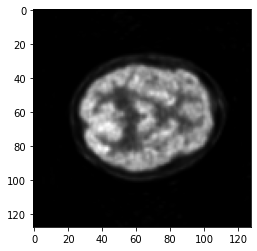

In [102]:
plt.imshow(dataset[0][:,:,32],cmap='gray')
plt.show()

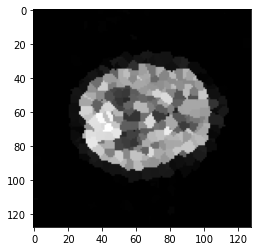

In [103]:
plt.imshow(converted[:,:,32],cmap='gray')
plt.show()

In [104]:
## Converting clusters to a datset
c_dataset = []

for c in clusters:
    c_dataset.append([c.x,c.y,c.z,c.i])
    
c_dataset = np.array(c_dataset)

In [105]:
#Scaling 
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(c_dataset)

In [106]:
scaled_dataset[:10,:]

array([[-1.60979495, -1.62771175, -1.56541256, -0.41088264],
       [-1.60979495, -1.62771175, -1.29589034, -0.41088264],
       [-1.60979495, -1.62771175, -1.02636811, -0.41088264],
       [-1.60979495, -1.62771175, -0.75684589, -0.41088264],
       [-1.60979495, -1.62771175, -0.48732366, -0.41088264],
       [-1.60979495, -1.62771175, -0.21780144, -0.41088264],
       [-1.60979495, -1.62771175,  0.05172079, -0.41088264],
       [-1.60979495, -1.62771175,  0.32124301, -0.41088264],
       [-1.60979495, -1.62771175,  0.59076524, -0.41088264],
       [-1.60979495, -1.62771175,  0.86028746, -0.41088264]])

In [598]:
## Converting clusters to a datset
c_dataset = []

for c in clusters:
    c_dataset.append([c.i])
    
c_dataset = np.array(c_dataset)

scaled_dataset = c_dataset.copy()

## K Means Clustering

In [599]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

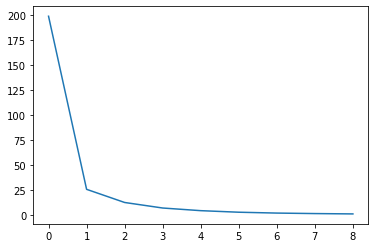

In [601]:
wcss = []
for i in range(1,10):
    k_clusters = KMeans(n_clusters=i)
    k_clusters.fit(scaled_dataset)
    wcss.append(k_clusters.inertia_)

plt.plot(wcss)
plt.show()
    

In [602]:
n_clusters = 3

In [603]:
k_clusters = KMeans(n_clusters=n_clusters)
k_clusters.fit(scaled_dataset)

KMeans(n_clusters=3)

In [604]:
lables = k_clusters.predict(scaled_dataset)

In [605]:
#Creating Segments
segments = []
shape = dataset[0].shape
for i in range(n_clusters):
    blank = np.zeros(shape)
    for c in np.array(clusters)[lables==i]:
        #blank[c.coord]=1.0
        for v in c.voxels.keys():
            blank[v] = 1.0
            
    
    segments.append(blank)

segments = np.array(segments)

In [606]:
level =55

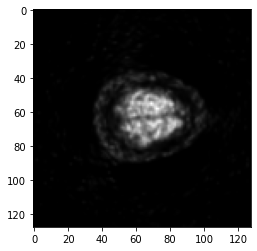

In [607]:
plt.imshow(dataset[0][:,:,level],cmap='gray')
plt.show()

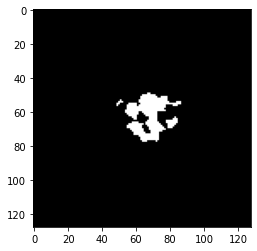

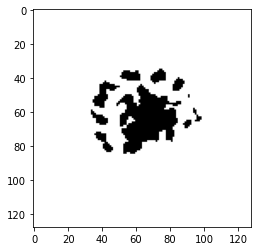

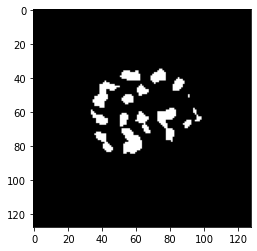

In [608]:
for seg in segments:
    plt.imshow(seg[:,:,level],cmap='gray')
    plt.show()

## Attempt with DBScan

In [715]:
dbscan = DBSCAN(eps=0.007,min_samples=15)
lables = dbscan.fit_predict(scaled_dataset)

In [716]:
len(set(lables))

6

In [717]:
#Creating Segments
segments = []
shape = dataset[0].shape
for i in set(lables):
    blank = np.zeros(shape)
    for c in np.array(clusters)[lables==i]:
        #blank[c.coord]=1.0
        for v in c.voxels.keys():
            blank[v] = 1.0
            
    
    segments.append(blank)

segments = np.array(segments)

In [718]:
level = 36

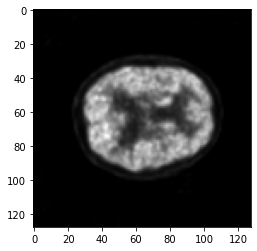

In [719]:
plt.imshow(dataset[0][:,:,level],cmap='gray')
plt.show()

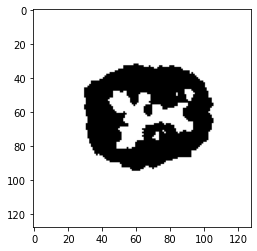

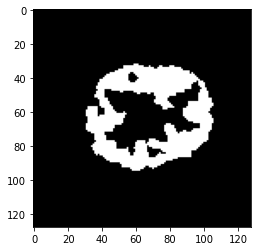

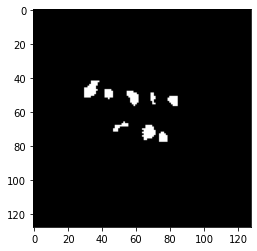

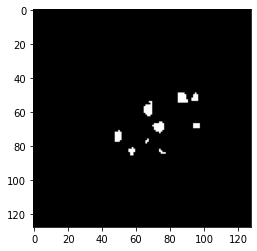

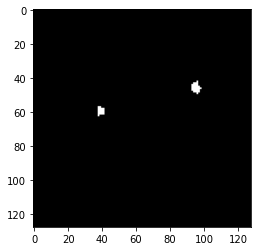

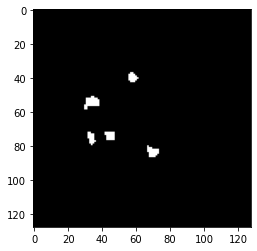

In [720]:
for seg in segments:
    plt.imshow(seg[:,:,level],cmap='gray')
    plt.show()

In [721]:
for i in set(lables):

    s = 0
    cnt = 0
    for c in np.array(clusters)[lables==i]:
        cnt += len(c.voxels.keys())
        for v in c.voxels.keys():
            s += dataset[0][v]
    print("For cluster ",i," mean = ",s/cnt)
            

For cluster  0  mean =  0.02135861658099042
For cluster  1  mean =  0.4834974535746884
For cluster  2  mean =  0.352125042407693
For cluster  3  mean =  0.2914349794645201
For cluster  4  mean =  0.6011516841347251
For cluster  -1  mean =  0.6191332380579616


## Trying Spectral Clustering

In [651]:
n_clusters = 5

In [653]:
sc = SpectralClustering(n_clusters=n_clusters)
lables = sc.fit_predict(scaled_dataset)

KeyboardInterrupt: 

In [529]:
#Creating Segments
segments = []
shape = dataset[0].shape
for i in range(n_clusters):
    blank = np.zeros(shape)
    for c in np.array(clusters)[lables==i]:
        #blank[c.coord]=1.0
        for v in c.voxels.keys():
            blank[v] = 1.0
            
    
    segments.append(blank)

segments = np.array(segments)

In [530]:
level = 36

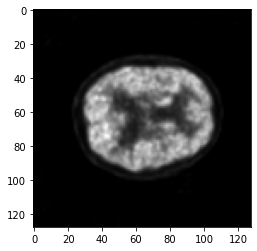

In [531]:
plt.imshow(dataset[0][:,:,level],cmap='gray')
plt.show()

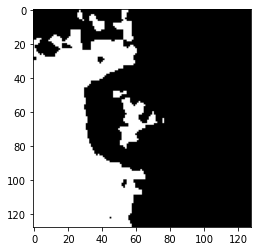

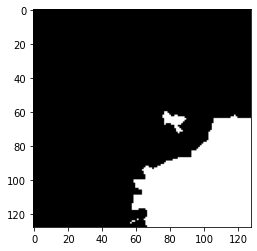

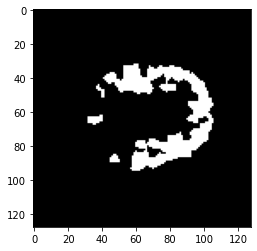

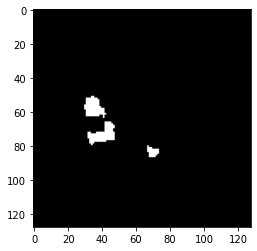

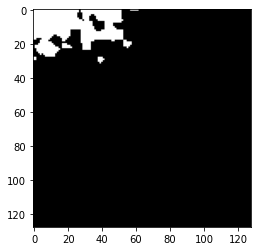

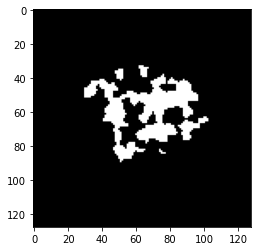

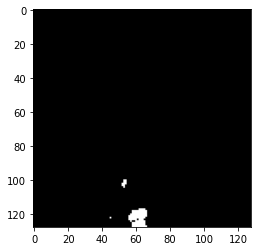

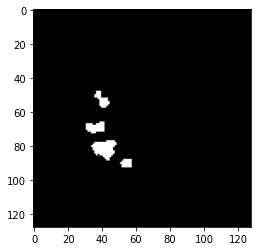

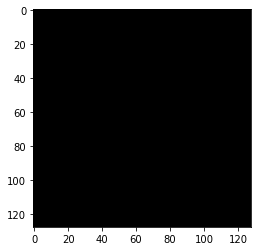

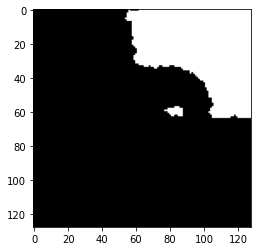

In [532]:
for seg in segments:
    plt.imshow(seg[:,:,level],cmap='gray')
    plt.show()

In [ ]:
for i in set(lables):

    s = 0
    cnt = 0
    for c in np.array(clusters)[lables==i]:
        cnt += len(c.voxels.keys())
        for v in c.voxels.keys():
            s += dataset[0][v]
    print("For cluster ",i," mean = ",s/cnt)
            